# Mission
Vous êtes Data Scientist au sein de l’entreprise "**Place de marché**”, qui souhaite lancer une marketplace e-commerce.

Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, **il devient nécessaire d'automatiser cette tâche**.

**Linda**, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un **moteur de classification** des articles en différentes catégories, avec un niveau de précision suffisant.

# Etape 2 : Classification supervisée
# 1. Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from matplotlib.image import imread
!pip install plot_keras_history # Colab
from plot_keras_history import show_history, plot_history
import time

import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn import metrics
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# 2. Préparation du dataset

## 2.1 Chemin d'accès au dossier de travail

In [5]:
chemin = "/content/drive/MyDrive/Yann Pham-Van - Data Scientist - OpenClassrooms/Projet6-Classifiez automatiquement des biens de consommation/data/cnn/"

## 2.2 Lecture du dataset

In [6]:
df = pd.read_csv("/content/drive/MyDrive/Yann Pham-Van - Data Scientist - OpenClassrooms/Projet6-Classifiez automatiquement des biens de consommation/data/cleaned/df_cleaned.csv")

In [7]:
df

,image,main_category,text
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,Sathiyas Cotton Bath Towel Specifications of S...
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,Eurospa Cotton Terry Face Towel Set Key Featur...
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,Jaipur Print Cotton Floral King sized Double B...
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,Oren Empower Extra Large Self Adhesive Sticker...
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,Wallmantra Large Vinyl Sticker Sticker Wallman...
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,Uberlyfe Extra Large Pigmented Polyvinyl Films...
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,Wallmantra Medium Vinyl Sticker Sticker Buy Wa...


### 2.2.1 Suppression de la colonne *text*

In [8]:
df = df.drop(columns=['text'])

### 2.2.2 Ajout d'une colonne *image_path*

In [9]:
df['image_path'] = "/content/drive/MyDrive/Yann Pham-Van - Data Scientist - OpenClassrooms/Projet6-Classifiez automatiquement des biens de consommation/data/source/Images/" + df['image']
df.head(1)

,image,main_category,image_path
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,/content/drive/MyDrive/Yann Pham-Van - Data Sc...


## 2.3 Encodage des catégories principales

In [10]:
le = preprocessing.LabelEncoder()
le.fit(df["main_category"])
df["label"] = le.transform(df["main_category"])
df.head()

,image,main_category,image_path,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,4


In [11]:
df.groupby("label").count()

,image,main_category,image_path
label,,,
0,150,150,150
1,150,150,150
2,150,150,150
3,150,150,150
4,150,150,150
5,150,150,150
6,150,150,150


## 2.4 Liste des catégories

In [12]:
list_labels = df["main_category"].unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

Home Furnishing
-------


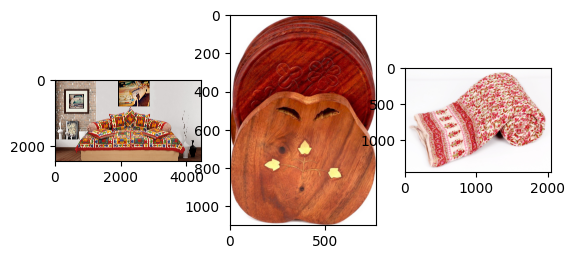

Baby Care
-------


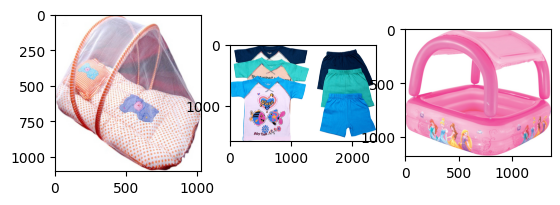

Watches
-------


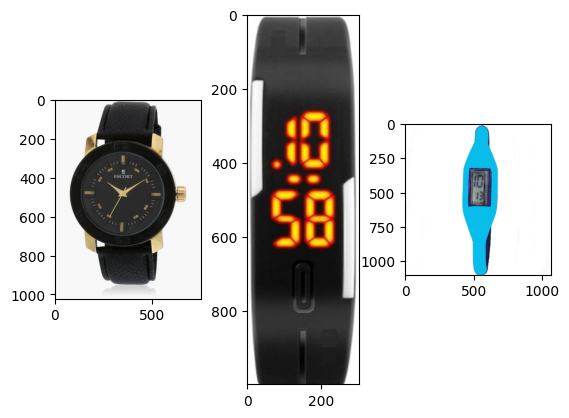

Home Decor & Festive Needs
-------


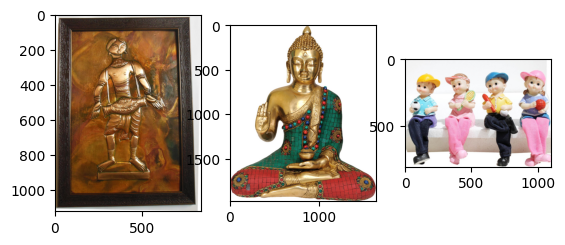

Kitchen & Dining
-------


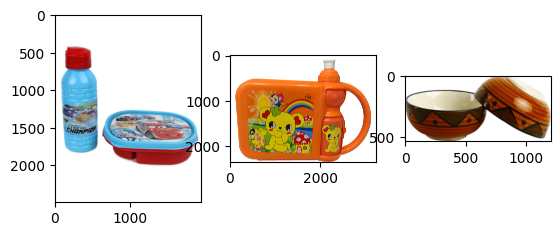

Beauty and Personal Care
-------


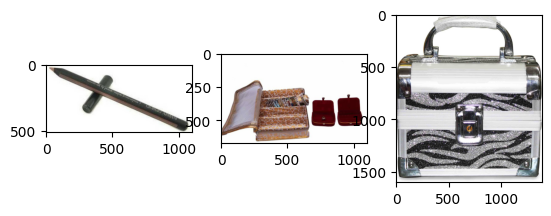

Computers
-------


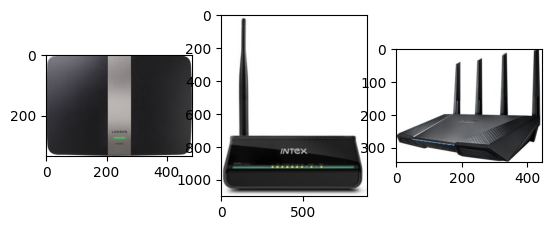

In [13]:
def list_fct(name) :
    list_image_name = [df["image"][i] for i in range(len(df)) if
                       df["main_category"][i]==name]
    return list_image_name

list_home_furnishing=[df["image"][i] for i in range(len(df)) if
                      df["main_category"][i]=="Home Furnishing"]
list_baby_care=[df["image"][i] for i in range(len(df)) if
                df["main_category"][i]=="Baby Care"]
list_watches=[df["image"][i] for i in range(len(df)) if
              df["main_category"][i]=="Watches"]
list_home_decor_festive_needs=[df["image"][i] for i in range(len(df)) if
                               df["main_category"][i]==
                               "Home Decor & Festive Needs"]
list_kitchen_dining=[df["image"][i] for i in range(len(df)) if
                     df["main_category"][i]=="Kitchen & Dining"]
list_beauty_personal_care=[df["image"][i] for i in range(len(df)) if
                           df["main_category"][i]=="Beauty and Personal Care"]
list_computers=[df["image"][i] for i in range(len(df)) if
                df["main_category"][i]=="Computers"]

for name in list_labels :
    print(name)
    print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i+10]
        image = imread("/content/drive/MyDrive/Yann Pham-Van - Data Scientist - OpenClassrooms/Projet6-Classifiez automatiquement des biens de consommation/data/source/Images/"+filename)
        plt.imshow(image)
    plt.show()

## 2.5 Création des dossiers destinés à contenir les données d'entraînement et de test
### 2.5.1 Suppression préalable de tout dossier pré-existant

In [14]:
shutil.rmtree(chemin+"dataset_train")
shutil.rmtree(chemin+"dataset_test")

### 2.5.2 Création des dossiers et sous-dossiers

In [15]:
for cat in list_labels:
  os.makedirs(chemin+"dataset_train/"+cat)
  os.makedirs(chemin+"dataset_test/"+cat)

In [16]:
path = chemin+"dataset_train/"
path_test = chemin+"dataset_test/"

## 2.6 Séparation du dataframe en jeux d'entraînement et de test

In [17]:
X = df['image']
y = df['main_category']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.2,
                                                    random_state=39)
X_train.shape

(840,)

In [19]:
data = df.iloc[X_train.index]
data_test = df.iloc[X_test.index]
data_test.head()

,image,main_category,image_path,label
65,2baa415ebcc4fe563ce13b50e60efc1c.jpg,Kitchen & Dining,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,5
888,f0bc8dff0e2ef0b75f1c78b4f67bcd63.jpg,Home Furnishing,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,4
638,aa68675f50a0551b8dadb954017a50a1.jpg,Kitchen & Dining,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,5
135,fd369a1bb58ae02cd925dda7e9e1d00a.jpg,Kitchen & Dining,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,5
701,14bc693d9b86c58696e5917045e9d4de.jpg,Home Furnishing,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,4


## 2.7 Affectation des images dans les sous-dossiers adéquats

In [20]:
chemin_image = "/content/drive/MyDrive/Yann Pham-Van - Data Scientist - OpenClassrooms/Projet6-Classifiez automatiquement des biens de consommation/data/source/Images/"
for i in X_train.index:
  shutil.copy(chemin_image+X_train[i], path+y_train[i])
for i in X_test.index:
  shutil.copy(chemin_image+X_test[i], path_test+y_test[i])

# 3. Classification supervisée
4 approches sont présentées :
- Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
- Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
- Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
- Une approche par DataSet, avec data augmentation intégrée au modèle : layer en début de modèle

## 3.1 Création du modèle de classification

In [21]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet",
                   input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop',
                  metrics=["accuracy"])

    print(model.summary())

    return model

## 3.2 Approche préparation initiale des images

In [22]:
top_depart = time.time()

def image_prep_fct(path) :
    prepared_images = []
    for image in glob(path+'*/*.jp*') :
        img = (load_img(
            image,
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(path)
print(images_np.shape)
images_np_test = image_prep_fct(path_test)
print(images_np_test.shape)

(840, 224, 224, 3)
(210, 224, 224, 3)


In [23]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y,
                                                  test_size=0.25,
                                                  random_state=39)
X_train.shape

(630, 224, 224, 3)

### 3.2.1 Création du modèle

In [25]:
with tf.device('/gpu:0'):
    model1 = create_model_fct()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

### 3.2.2 Création du callback

In [26]:
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss',
                             verbose=1,
                             save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

### 3.2.3 Entraîner sur les données d'entraînement (X_train, y_train)

In [27]:
batch_size=32

with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs=50,
                          batch_size=batch_size,
                          callbacks=callbacks_list,
                          validation_data=(X_val, y_val),
                          verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 9.6032 - accuracy: 0.1587
Epoch 1: val_loss improved from inf to 4.01649, saving model to ./model1_best_weights.h5
20/20 [==============================] - 26s 504ms/step - loss: 9.6032 - accuracy: 0.1587 - val_loss: 4.0165 - val_accuracy: 0.1190
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 4.1496 - accuracy: 0.2143
Epoch 2: val_loss improved from 4.01649 to 3.16643, saving model to ./model1_best_weights.h5
20/20 [==============================] - 4s 203ms/step - loss: 4.1496 - accuracy: 0.2143 - val_loss: 3.1664 - val_accuracy: 0.1143
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 2.7238 - accuracy: 0.2778
Epoch 3: val_loss improved from 3.16643 to 2.85614, saving model to ./model1_best_weights.h5
20/20 [==============================] - 3s 174ms/step - loss: 2.7238 - accuracy: 0.2778 - val_loss: 2.8561 - val_accuracy: 0.1333
Epoch 4/50
20/20 [==============================]

### 3.2.4 Score du dernier epoch

In [28]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 3s 126ms/step - loss: 0.4222 - accuracy: 0.9254
Training Accuracy: 0.9254

7/7 [==============================] - 1s 122ms/step - loss: 3.0463 - accuracy: 0.0762
Validation Accuracy:  0.0762


### 3.2.5 Score de l'epoch optimal

In [29]:
model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.1095
Test Accuracy       :  0.1190


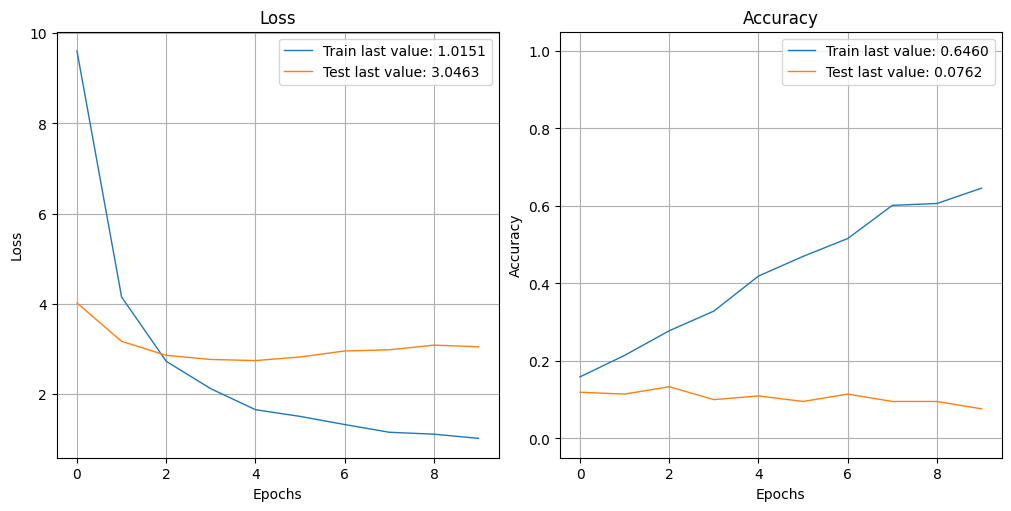

Temps de traitement Approche simple :           332.65 secondes


In [30]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

duration1 = time.time() - top_depart
print("Temps de traitement Approche simple : ",
      "%15.2f" % duration1, "secondes")

In [31]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 1s 129ms/step
[0 3 3 6 3 6 1 6 6 3 5 2 5 2 5 0 2 2 4 2 3 1 0 5 3 5 2 0 4 6 6 3 1 1 1 5 6
 5 2 1 6 2 3 2 4 4 5 0 1 5 2 6 6 6 2 0 3 4 2 0 0 2 6 5 3 5 0 0 3 2 1 4 2 0
 4 6 4 5 3 0 2 5 1 1 2 6 1 4 0 2 4 4 1 1 5 2 3 5 6 1 3 5 4 5 4 2 0 6 1 2 2
 4 6 1 0 2 3 6 0 6 6 2 3 4 1 3 3 5 3 1 0 3 4 3 4 3 2 5 6 4 0 3 1 0 0 4 4 2
 5 3 6 6 0 1 1 0 0 0 5 5 4 6 5 4 5 6 4 3 5 1 2 1 1 6 4 6 5 5 1 6 1 3 5 0 0
 4 4 3 0 1 0 0 3 4 6 4 2 5 1 6 0 2 5 4 3 1 3 1 2 4]

[2 4 1 0 4 2 6 4 5 4 2 6 5 5 4 5 5 5 3 1 0 4 2 5 5 4 4 0 6 6 5 0 1 6 2 6 0
 4 3 3 3 3 1 1 6 5 6 4 1 6 4 6 1 3 6 5 3 6 6 2 0 5 4 0 6 4 6 5 0 5 6 3 3 1
 0 3 6 6 4 6 1 6 6 6 6 1 0 0 2 5 5 2 4 6 6 6 6 0 4 4 4 6 1 1 0 4 6 0 2 1 4
 0 0 4 6 5 3 0 6 6 4 2 6 0 0 3 1 6 0 0 4 6 5 6 5 2 6 2 1 2 4 5 5 2 1 6 2 4
 3 5 5 3 3 5 6 5 1 6 5 5 6 3 5 6 0 6 5 4 1 5 3 1 0 1 5 6 3 0 0 6 0 6 0 4 4
 0 3 5 6 1 3 5 1 5 6 6 6 0 0 1 1 0 1 6 4 5 0 0 6 4]


In [32]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[2 4 5 2 5 5 7]
 [8 4 2 1 4 4 7]
 [1 4 1 4 5 7 8]
 [5 4 1 3 7 4 6]
 [6 1 3 3 1 7 9]
 [6 3 2 2 4 5 8]
 [5 5 1 5 4 3 7]]


In [33]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [1,5,0,2,4,3,6]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

In [34]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [1, 5, 0, 2, 4, 3, 6]
[[5 2 2 5 5 4 7]
 [2 8 1 4 4 4 7]
 [1 1 4 7 5 4 8]
 [1 5 3 4 7 4 6]
 [3 6 3 7 1 1 9]
 [2 6 2 5 4 3 8]
 [1 5 5 3 4 5 7]]

              precision    recall  f1-score   support

           0       0.33      0.17      0.22        30
           1       0.24      0.27      0.25        30
           2       0.20      0.13      0.16        30
           3       0.11      0.13      0.12        30
           4       0.03      0.03      0.03        30
           5       0.12      0.10      0.11        30
           6       0.13      0.23      0.17        30

    accuracy                           0.15       210
   macro avg       0.17      0.15      0.15       210
weighted avg       0.17      0.15      0.15       210



<Axes: >

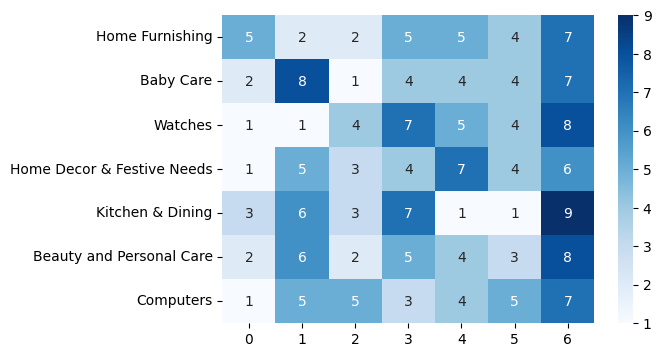

In [35]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## 3.3 Approche ImageDatagenerator avec data augmentation
### 3.3.1 Mélange des images, initialement rangées par classe

In [36]:
top_depart = time.time()

data = data.sample(frac=1, random_state=39).reset_index(drop=True)
data

,image,main_category,image_path,label
0,3830dda3491cd5b28ed42ae544bc44f0.jpg,Kitchen & Dining,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,5
1,95feec21a9d076cff084159d61bf9b8e.jpg,Baby Care,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,0
2,15f45d08050e8ba24a14804cba000589.jpg,Beauty and Personal Care,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,1
3,04f9f818e2d657b873b07578cfe2eade.jpg,Home Decor & Festive Needs,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,3
4,14826adf9bc4c34ea566dae3d85ef7cf.jpg,Watches,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,6
...,...,...,...,...
835,25ce025c38c55f28fd0ea3bb0200df79.jpg,Baby Care,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,0
836,0991e8d8f884003ab18890971191085d.jpg,Baby Care,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,0
837,113783ce1db999778b5a4bd374e61209.jpg,Watches,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,6
838,d218c32df572e82db50faecd62179db2.jpg,Home Furnishing,/content/drive/MyDrive/Yann Pham-Van - Data Sc...,4


In [37]:
def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                            x_col='image_path',
                                            y_col='main_category',
                                            weight_col=None,
                                            target_size=(256, 256),
                                            classes=None,
                                            class_mode='categorical',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=39,
                                            subset=data_type
                                            )
    return data_flow

In [38]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


### 3.3.2 Création du modèle

In [39]:
with tf.device('/gpu:0'):
    model2 = create_model_fct()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### 3.3.3 Création du callback

In [40]:
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss',
                             verbose=1,
                             save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [41]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [42]:
with tf.device('/gpu:0'):
    history2 = model2.fit(train_flow,
                          validation_data=val_flow,
                          batch_size=batch_size, epochs=50,
                          callbacks=callbacks_list,
                          verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 3.8378 - accuracy: 0.4540
Epoch 1: val_loss improved from inf to 1.40324, saving model to ./model2_best_weights.h5
20/20 [==============================] - 42s 2s/step - loss: 3.8378 - accuracy: 0.4540 - val_loss: 1.4032 - val_accuracy: 0.6810
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.4585 - accuracy: 0.6476
Epoch 2: val_loss improved from 1.40324 to 1.16650, saving model to ./model2_best_weights.h5
20/20 [==============================] - 26s 1s/step - loss: 1.4585 - accuracy: 0.6476 - val_loss: 1.1665 - val_accuracy: 0.7333
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.9756 - accuracy: 0.7429
Epoch 3: val_loss improved from 1.16650 to 1.04191, saving model to ./model2_best_weights.h5
20/20 [==============================] - 25s 1s/step - loss: 0.9756 - accuracy: 0.7429 - val_loss: 1.0419 - val_accuracy: 0.7381
Epoch 4/50
20/20 [==============================] - ETA:

### 3.3.4 Score du dernier epoch

In [43]:
loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 20s 996ms/step - loss: 0.1061 - accuracy: 0.9683
Training Accuracy   : 0.9683

7/7 [==============================] - 6s 768ms/step - loss: 1.1191 - accuracy: 0.7905
Validation Accuracy :  0.7905


### 3.3.5 Score de l'epoch optimal

In [44]:
model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.7714
Test Accuracy       :  0.8143


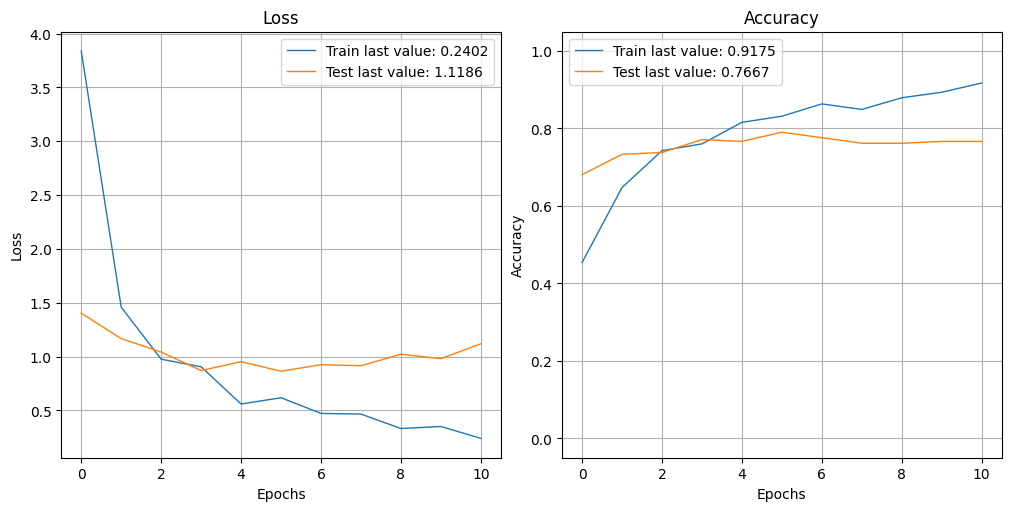

Temps de traitement ImageDatagenerator avec data augmentation :           376.37 secondes


In [45]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

duration2 = time.time() - top_depart
print("Temps de traitement ImageDatagenerator avec data augmentation : ",
      "%15.2f" % duration2, "secondes")

## 3.4 Approche nouvelle par Dataset sans data augmentation

In [46]:
top_depart = time.time()

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size,
                    image_size=(224, 224), shuffle=True, seed=39,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [47]:
dataset_train = dataset_fct(path, validation_split=0.25,
                            data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25,
                          data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0,
                           data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


### 3.4.1 Création du modèle

In [48]:
with tf.device('/gpu:0'):
    model3 = create_model_fct()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### 3.4.2 Création du callback

In [49]:
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss',
                             verbose=1,
                             save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [50]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [51]:
with tf.device('/gpu:0'):
    history3 = model3.fit(dataset_train,
                          validation_data=dataset_val,
                          batch_size=batch_size, epochs=50,
                          callbacks=callbacks_list,
                          verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 5.2723 - accuracy: 0.5032
Epoch 1: val_loss improved from inf to 1.58245, saving model to ./model3_best_weights.h5
20/20 [==============================] - 15s 470ms/step - loss: 5.2723 - accuracy: 0.5032 - val_loss: 1.5825 - val_accuracy: 0.7143
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 2.0051 - accuracy: 0.7079
Epoch 2: val_loss improved from 1.58245 to 1.39153, saving model to ./model3_best_weights.h5
20/20 [==============================] - 10s 379ms/step - loss: 2.0051 - accuracy: 0.7079 - val_loss: 1.3915 - val_accuracy: 0.7619
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.2937 - accuracy: 0.7667
Epoch 3: val_loss improved from 1.39153 to 1.15811, saving model to ./model3_best_weights.h5
20/20 [==============================] - 12s 388ms/step - loss: 1.2937 - accuracy: 0.7667 - val_loss: 1.1581 - val_accuracy: 0.7571
Epoch 4/50
20/20 [=============================

### 3.4.3 Score du dernier epoch

In [52]:
loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 9s 300ms/step - loss: 0.0121 - accuracy: 0.9984
Training Accuracy   : 0.9984

7/7 [==============================] - 3s 133ms/step - loss: 1.1223 - accuracy: 0.8143
Validation Accuracy :  0.8143


### 3.4.5 Score de l'epoch optimal

In [53]:
model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.7810
Test Accuracy       :  0.8238


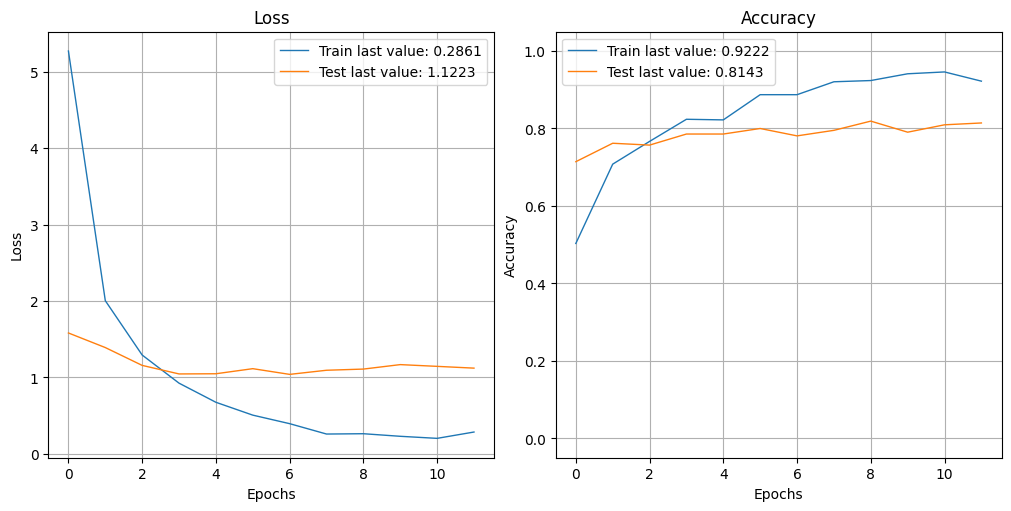

Temps de traitement Dataset sans data augmentation :           181.53 secondes


In [54]:
show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

duration3 = time.time() - top_depart
print("Temps de traitement Dataset sans data augmentation : ",
      "%15.2f" % duration3, "secondes")

## 3.5 Approche nouvelle par Dataset avec data augmentation intégrée au modèle

In [55]:
top_depart = time.time()

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size,
                    image_size=(224, 224), shuffle=True, seed=39,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [56]:
dataset_train = dataset_fct(path, validation_split=0.25,
                            data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25,
                          data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0,
                           data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


### 3.5.1 Nouvelle fonction de création de modèle incluant la data augmentation

In [57]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])

    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet",
                       input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam',
                  metrics=["accuracy"])

    print(model.summary())

    return model

### 3.5.2 Création du modèle

In [58]:
with tf.device('/gpu:0'):
    model4 = create_model_fct2()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

### 3.5.3 Création du callback

In [59]:
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss',
                             verbose=1,
                             save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                   patience=5)
callbacks_list = [checkpoint, es]

In [60]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
with tf.device('/gpu:0'):
    history4 = model4.fit(dataset_train, validation_data=dataset_val,
                          batch_size=batch_size, epochs=50,
                          callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.8888 - accuracy: 0.2476
Epoch 1: val_loss improved from inf to 1.50971, saving model to ./model4_best_weights.h5
20/20 [==============================] - 13s 440ms/step - loss: 1.8888 - accuracy: 0.2476 - val_loss: 1.5097 - val_accuracy: 0.4048
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.4527 - accuracy: 0.4825
Epoch 2: val_loss improved from 1.50971 to 1.13956, saving model to ./model4_best_weights.h5
20/20 [==============================] - 13s 516ms/step - loss: 1.4527 - accuracy: 0.4825 - val_loss: 1.1396 - val_accuracy: 0.6810
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.1870 - accuracy: 0.6222
Epoch 3: val_loss improved from 1.13956 to 0.98073, saving model to ./model4_best_weights.h5
20/20 [==============================] - 13s 511ms/step - loss: 1.1870 - accuracy: 0.6222 - val_loss: 0.9807 - val_accuracy: 0.7143
Epoch 4/50
20/20 [=============================

### 3.5.4 Score du dernier epoch

In [ ]:
loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

### 3.5.5 Score de l'epoch optimal

In [ ]:
model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

In [ ]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

duration4 = time.time() - top_depart
print("Temps de traitement Dataset avec data augmentation : ",
      "%15.2f" % duration4, "secondes")